## Enron Email Classification using Word Embeddings and LSTM

you can find pre-processing of 'preprocessed.csv' for machine learning classifiers at:

[https://www.kaggle.com/ankur561999/enron-email-classification-using-machine-learning](https://www.kaggle.com/ankur561999/enron-email-classification-using-machine-learning)

and data cleaning of enron email dataset at:

[https://www.kaggle.com/ankur561999/data-cleaning-enron-email-dataset](https://www.kaggle.com/ankur561999/data-cleaning-enron-email-dataset)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin
/kaggle/input/enron-email-classification-using-machine-learning/preprocessed.csv
/kaggle/input/enron-email-classification-using-machine-learning/f1_score.csv
/kaggle/input/enron-email-classification-using-machine-learning/__results__.html
/kaggle/input/enron-email-classification-using-machine-learning/__notebook_source__.ipynb
/kaggle/input/enron-email-classification-using-machine-learning/__resultx__.html
/kaggle/input/enron-email-classification-using-machine-learning/__notebook__.ipynb
/kaggle/input/enron-email-classification-using-machine-learning/accuracy.csv
/kaggle/input/enron-email-classification-using-machine-learning/jacc_score.c

## 1. Import necessary libraries

In [4]:
# !pip install keras
# !pip install tensorflow

                                              0.0/276.6 MB ? eta -:--:--
                                            0.0/276.6 MB 991.0 kB/s eta 0:04:40
                                              0.2/276.6 MB 2.4 MB/s eta 0:01:57
                                              0.5/276.6 MB 3.9 MB/s eta 0:01:12
                                              0.5/276.6 MB 3.7 MB/s eta 0:01:15
                                              0.5/276.6 MB 3.7 MB/s eta 0:01:15
                                              0.5/276.6 MB 3.7 MB/s eta 0:01:15
                                              0.5/276.6 MB 3.7 MB/s eta 0:01:15
                                              0.5/276.6 MB 3.7 MB/s eta 0:01:15
                                              0.5/276.6 MB 3.7 MB/s eta 0:01:15
                                              0.5/276.6 MB 3.7 MB/s eta 0:01:15
                                              0.5/276.6 MB 3.7 MB/s eta 0:01:15
                                              0

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\DataInsight GPU\\AppData\\Roaming\\Python\\Python311\\site-packages\\~umpy\\.libs\\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, LSTM, Flatten, Embedding
from keras.utils import to_categorical
from keras.backend import clear_session

## 2. Load Pre-trained Embeddings

#### 2.1 Google's Word Embeddings

In [ ]:
# load Google's pre-trained word2vec embeddings
filename = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"

start = time.time()
google_embeddings = KeyedVectors.load_word2vec_format(filename, binary=True)

print("Load time (seconds): ", (time.time() - start))

#### 2.2 Stanford's Word Embeddings

In [ ]:
# load Stanford's pre-trained GloVe embeddings
glove_file = "/kaggle/input/glove-embeddings/glove.6B.300d.txt"
glove_word2vec_file = "glove.6B.100d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

In [ ]:
# glove embeddings
start = time.time()

glove_embeddings = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)

print("Load time (seconds): ", (time.time() - start))

## 3. Load Data

In [3]:
# load data
data = pd.read_csv("/kaggle/input/enron-email-classification-using-machine-learning/preprocessed.csv")

# view first 5 rows of the dataframe 'data'
data.head()

,X-Folder,text
0,california,caiso notice summer 2001 generation rfb market...
1,california,ca iso cal px information related 2000 market ...
2,california,caiso notification update inter sc trades adju...
3,california,update mif meeting presentations iso website u...
4,california,mif presentations presentations market issues ...


## 4. Prepare Data

In [4]:
# shape of the data
data.shape

(13586, 2)

#### 4.1 Encode class labels

In [5]:
# count number of instances in each folder
data['X-Folder'].unique()

array(['california', 'calendar', 'resumes', 'archives', 'junk file',
       'ces', 'logistics', 'tufco', 'projects', 'online trading',
       'management', 'esvl', 'ooc', 'corporate', 'tw-commercial group',
       'genco-jv_ipo', 'junk', 'deal discrepancies', 'e-mail bin',
       'bill williams iii'], dtype=object)

In [6]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['X-Folder'])
    return y

In [7]:
y = label_encoder(data)
input_data = data['text']

In [8]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_data, y, test_size=0.1)

In [9]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 20)
Y_test = to_categorical(y_test, 20)

In [10]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data)
vocab_size = len(t.word_index) + 1

# integer encode the documents
X_train_encoded_docs = t.texts_to_sequences(X_train)
X_test_encoded_docs = t.texts_to_sequences(X_test)

In [11]:
# pad documents to a max length of 150 words
max_length = 150
X_train_padded_docs = pad_sequences(X_train_encoded_docs, maxlen=max_length, padding='post')
X_test_padded_docs = pad_sequences(X_test_encoded_docs, maxlen=max_length, padding='post')

print(X_train_padded_docs[0])

[   22  2942     3  1906   925  1145    12    22  2942     3   114  1028
    14    84  3172    64    48  1033  1028   732  1906    54  3172  1028
   732  1906     6    96    46  3172  2942     3   406  3172  2942     3
  3638  6619  7261  3172    64    48  1397  1406  1192   366   688   273
    38    39    50    99   867    54  1406  1192   366  2526   171    22
  2942     3  1906  3169   366  1145    12    22  2942     3  1906  3169
   366  1145    96    40  4056     1     3   128  3012     3    12  4809
   147  4398  1114 29254 11512  9596    53    12  6275  6498  6952  3012
     3   400  1357   265  1982    12  1369   662     3   662  1114    53
  2270  2482  1612  4056     1     3  1432  1092    12  1369   662     3
   662  1114    53  2270  2482  1612  4056     1     3   444  1765   539
    12  1369   662     3   662  3097  1114  3073  2790   118    12    22
  3657     3   888  1114    20 10270]


## 5. Using Google's Pre-trained Word Embeddings

In [12]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = google_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [13]:
# define the model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, dropout=0.2))
model.add(Flatten())
model.add(Dense(20, activation='softmax'))


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 300)          17877600  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
Total params: 18,040,020
Trainable params: 162,420
Non-trainable params: 17,877,600
_________________________________________________________________


In [ ]:
clear_session()

In [ ]:
# train the model
clear_session()
history = model.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1)

In [ ]:
# evaluate the model on the test set
accr = model.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr[0], accr[1]))

In [ ]:
# plot the loss
plt.title("Word2Vec Loss")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# plot the accuracy
plt.title("Word2Vec Accuracy")
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

## 6. Using GloVe Word Embeddings

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [ ]:
# define the model
model2 = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model2.add(e)
model2.add(LSTM(100, dropout=0.2))
model2.add(Flatten())
model2.add(Dense(20, activation='softmax'))


# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model2.summary()

In [ ]:
# fit the model
history2 = model2.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1)

In [ ]:
# evaluate the model2 on the test set
accr2 = model2.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr2[0], accr2[1]))

In [ ]:
# plot the loss
plt.title("Glove Word2Vec Loss")
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# plot the accuracy
plt.title("GloVe Word2Vec Accuracy")
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

## 7. Word Embeddings using Training Data

In [15]:
# define the model
model3 = Sequential()
model3.add(Embedding(vocab_size, 300, input_length=max_length))
model3.add(LSTM(100, dropout=0.4))
model3.add(Flatten())
model3.add(Dense(20, activation='softmax'))

# compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 300)          17877600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
Total params: 18,040,020
Trainable params: 18,040,020
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train the model
history3 = model3.fit(X_train_padded_docs, Y_train, validation_split=0.1, epochs=20, verbose=1)

Epoch 1/20
344/344 [==============================] - 99s 287ms/step - loss: 2.8360 - accuracy: 0.1295 - val_loss: 2.7014 - val_accuracy: 0.1643
Epoch 2/20
344/344 [==============================] - 98s 286ms/step - loss: 2.5721 - accuracy: 0.2120 - val_loss: 2.6553 - val_accuracy: 0.2011
Epoch 3/20
344/344 [==============================] - 98s 286ms/step - loss: 2.3783 - accuracy: 0.2683 - val_loss: 2.4676 - val_accuracy: 0.2567
Epoch 4/20
344/344 [==============================] - 104s 301ms/step - loss: 2.1415 - accuracy: 0.3509 - val_loss: 2.6740 - val_accuracy: 0.2167
Epoch 5/20
344/344 [==============================] - 100s 289ms/step - loss: 2.0939 - accuracy: 0.3650 - val_loss: 2.4105 - val_accuracy: 0.2805
Epoch 6/20
344/344 [==============================] - 101s 293ms/step - loss: 2.0246 - accuracy: 0.3925 - val_loss: 2.1268 - val_accuracy: 0.3606
Epoch 7/20
344/344 [==============================] - 102s 295ms/step - loss: 1.7643 - accuracy: 0.4642 - val_loss: 1.8698 - va

In [24]:
# save learned word embeddings
own_embeddings = model3.get_layer('embedding_2').get_weights()[0]

custom_w2v = {}

for word, index in t.word_index.items():
    custom_w2v[word] = own_embeddings[index]
    
import pickle    
# save to file
with open("own_embeddings.pkl", "wb") as handle:
    pickle.dump(custom_w2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
# load own_embeddings
#with open("own_embeddings.pkl", "rb") as handle:
 #   own_embeddings = pickle.load(handle)

In [26]:
# evaluate the model
accr3 = model3.evaluate(X_test_padded_docs, Y_test)

print("Test Set:\n  Loss: {:0.3f}\n   Accuracy: {:0.3f}".format(accr3[0], accr3[1]))

43/43 [==============================] - 2s 41ms/step - loss: 1.0733 - accuracy: 0.7513
Test Set:
  Loss: 1.073
   Accuracy: 0.751


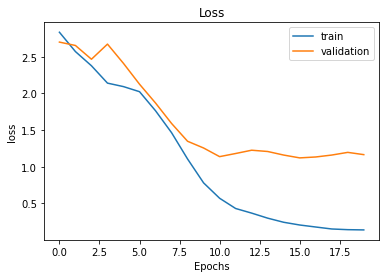

In [27]:
# plot the loss
plt.title("Loss")
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

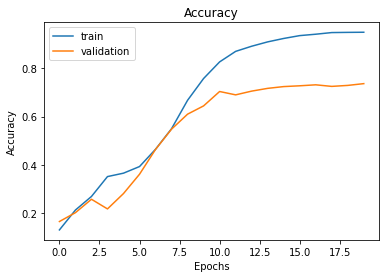

In [28]:
# plot the accuracy
plt.title("Accuracy")
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

## 8. Results

In [ ]:
# create a dataframe to store results
res_data = {
    "Technique": ['Word2Vec', 'GloVe', 'Training data Embeddings'],
    "test accuracy": [accr[1], accr2[1], accr3[1]]
}
result = pd.DataFrame(res_data)
result

- **Word2Vec:** Google's pre-trained word embeddings Google news data (about 100 billion words).
- **GloVe:** Stanford's pre-trained word embeddings trained on Wikipedia data with 6 billion tokens and a 400,000 word vocabulary.
-  **Training data Embeddings:** Embeddings learned from training data
- LSTM with one hidden layer and 100 units has been trained to classify folders based on these word embeddings.

In [ ]:
data.shape